In [1]:
%matplotlib inline
# Add the application folder to the path
import sys
sys.path.insert(0,'../Peergrade/peergrade/')

import application.model as data_model
from collections import defaultdict
import numpy as np
from bson.objectid import ObjectId
from matplotlib import pyplot as plt

SETUP LINK TO REDIS CACHE redis://localhost:6379
Initializing SAML...
Loading local database


In [2]:
class Grader(object):
    def __init__(self, name):
        self.name = name
        self.handins = list()
        
    def add_handin(self, handin):
        self.handins.append(handin)

class Handin:
    def __init__(self,title,owner):
        self.title = title
        self.owner = owner
        self.gradeings = dict()
        self.graders = list()
    
    def add_grader(self,grader):
        self.graders.append(grader)
        
    def add_gradeing(self,grader,value):
        self.gradeings[grader.name] = value

        
class Assignment(object):
    
    def __init__(self, handins_input, graders_input,n_gradings):
        self.handins = dict()
        self.graders = dict()
        self.n_gradings = n_gradings
        for handin in handins_input:
            self.handins[handin.title] = handin
        for grader in graders_input:
            self.graders[grader.name] = grader
    
    def add_handin(self, handin):
        self.handing[handin.title] = handin
        
    def add_grader(self, grader):
        self.graders[grader.title] = grader
            
class Course(object):
    
    def __init__(self):
        self.assignments = list()
        self.handins = dict()
        self.graders = dict()
        self.n_gradings = 0
    
    def add_assignment(self,assignment):
        self.assignments.append(assignment)
        for a in self.assignments:
            self.handins.update(a.handins)
            self.graders.update(a.graders)
        self.n_gradings = self.n_gradings + a.n_gradings

In [208]:
def user_name(user_id):
    user = data_model.User.objects.get(id=user_id)
    return user.name

def question_max_value(question):
    if question.question_type == "boolean":
        return 1
    elif question.question_type == "numerical":
        if question.numericalAnswers:
            max_value = max(map(int,question.numericalAnswers.keys()))
            return max_value
        else:
            return 5

def answer_value(answer):
    if answer.numerical_answer != None:
        return answer.numerical_answer / float(question_max_value(answer.question))
    if answer.boolean_answer != None:
        return answer.boolean_answer / float(question_max_value(answer.question))

def score_handin(report_grade):
    answers = data_model.Answer.objects(report_grade=report_grade)
    handin_n = 0.0
    handin_acc = 0.0
    for answer in answers:
        if answer.text_answer == None:
            handin_acc = handin_acc + answer_value(answer)
            handin_n = handin_n + 1.0
    return handin_acc / handin_n


In [5]:
def fetch_assignment_data(ass_obj):
    '''
    Takes an course and assignment data model object and transforms it into populated Assignment object
    Only student or all?
    '''

    ## Find all graders
    graders = dict()
    for student_ in ass_obj.course.students:
        graders[str(student_.id)] = Grader(str(student_.id))
    
    ## Find all handins
    handins = dict()
    for handin_ in data_model.Handin.objects(assignment=ass_obj):
        handins[str(handin_.id)] = Handin(str(handin_.id),str(handin_.submitter.id))
        
    ## Find all handins graders have graded and vice versa
    n_gradings = 0
    for handin_ in data_model.Handin.objects(assignment=ass_obj):
        for grade in data_model.ReportGrade.objects(handin=handin_,state='ANSWERED'):
            n_gradings = n_gradings + 1
            
            # Needed if TA or Professor have graded reports as they are not initialy part of it
            if str(grade.giver.id) not in graders:
                graders[str(grade.giver.id)] = Grader(str(grade.giver.id))

            handins[str(handin_.id)].add_grader(graders[str(grade.giver.id)])
            handins[str(handin_.id)].add_gradeing(graders[str(grade.giver.id)],score_handin(grade))
            
    ## update reference in graders
    for handin in handins.itervalues():
        for grader in handin.graders:
            grader.add_handin(handin)

    return Assignment(handins.itervalues(),graders.itervalues(),n_gradings)

In [6]:
def fetch_data(obj):

    res_c = Course()
        
    if type(obj).__name__ == "Course":
        assignments_d = data_model.Assignment.objects(course=obj)
        for assignment_d in assignments_d:
            res_c.add_assignment(fetch_assignment_data(assignment_d))
    elif type(obj).__name__ == "Assignment":
        res_c.add_assignment(fetch_assignment_data(obj))
        
    return res_c

In [7]:
c = data_model.Course.objects.get(title="Computational Tools for Big Data")

In [8]:
t = fetch_data(c)

In [276]:
def gibbs_model(data):
    
    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    N_g = data.n_gradings   # Number of gradings
    N_eval = N_g*N_G   # Number of evaluations in total
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_e = 10.0
    be_e = 1.0
    t_h = 500.0
    t_g = 100.0
    
    # Prior parameters
    u_h = dict()
    t_h = dict()
    u_g = dict()
    t_g = dict()
    T = dict()
    B = dict()

    # Draw from priors
    e = np.random.gamma(al_e,1.0/be_e)
    for h in data.handins.iterkeys():
        t_h[h] = np.random.gamma(al_h,1.0/be_h)
        u_h[h] = np.random.normal(ga_h,np.sqrt(1.0/(la_g * t_h[h])))
        T[h] = np.random.normal(u_h[h],np.sqrt(1.0/t_h[h]))
    for g in data.graders.iterkeys():
        t_g[g] = np.random.gamma(al_g,1.0/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1.0/(la_g * t_g[g])))
        B[g] = np.random.normal(u_g[g],np.sqrt(1.0/t_g[g]))

    # Gibbs sampling
    
    burn_in = 1000  # warm-up steps
    samples = 5000 # Gibbs sampling steps
    
    # Tracers initialising
    acc_e = 0
    acc_u_h = defaultdict(lambda : 0)
    acc_t_h = defaultdict(lambda : 0)
    acc_u_g = defaultdict(lambda : 0)
    acc_t_g = defaultdict(lambda : 0)
    acc_T = defaultdict(lambda : 0)
    acc_B = defaultdict(lambda : 0)

    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),
        # Sample T
        for h, handin in data.handins.iteritems():
            n_gradings = len(handin.graders)
            sum_ = 0.0
            for g, val in handin.gradeings.iteritems():
                sum_ = sum_ + val - B[g]
            v = e*n_gradings+t_h[h]
            T[h] = np.random.normal((u_h[h]*t_h[h]+e*sum_)/v,np.sqrt(1/v))
            
        # Sample B
        for g, grader in data.graders.iteritems():
            n_gradings = len(grader.handins)
            sum_ = 0.0
            for h in grader.handins:
                sum_ = sum_ + h.gradeings[g] - T[h.title]
            v = e*n_gradings+t_g[g]
            B[g] = np.random.normal((u_g[g]*t_g[g]+e*sum_)/v,np.sqrt(1/v))
        
        # Sample e
        sum_ = 0.0
        n_eval = 0.0
        for h, handin in data.handins.iteritems():
            for g, grading in data.handins[h].gradeings.iteritems():
                sum_ = sum_ + np.square(grading - (T[h]+B[g]))
                n_eval = n_eval + 1.0
        e = np.random.gamma(al_e+0.5*n_eval,1.0/(be_e+0.5*sum_))

        # Sample u_h and t_h
        for h in data.handins.iterkeys():
            la_ = (la_h+1.0)
            al_ = al_h + 0.5 * la_h + 0.5 * np.square(T[h]-u_h[h])
            be_ = be_h + 0.5 + 0.5 * 1.0
#            al_ = al_h+0.5
#            be_ = be_h+0.5*((la_h*np.square(T[h]-ga_h))/la_)
            t_h[h] = np.random.gamma(al_,1.0/be_)
            u_h[h] = np.random.normal((la_h*ga_h+T[h])/la_,np.sqrt(1.0/(la_*t_h[h])))

        # Sample u_g and t_g
        for g in data.graders.iterkeys():
            la_ = (la_g+1.0)
            al_ = al_g + 0.5 * la_g + 0.5 * np.square(B[g]-u_g[g])
            be_ = be_g + 0.5 + 0.5 * 1.0
#            al_ = al_g+0.5
#            be_ = be_g+0.5*((la_g*np.square(B[g]-ga_g))/la_)
            t_g[g] = np.random.gamma(al_,1.0/be_)
            u_g[g] = np.random.normal((la_g*ga_g+B[g])/la_,np.sqrt(1.0/(t_g[g])))
            
        # Collect tracings
        if r > burn_in:
            acc_e = acc_e + e
            for h in data.handins.iterkeys():
                acc_u_h[h] = acc_u_h[h] + u_h[h]
                acc_t_h[h] = acc_t_h[h] + t_h[h]
                acc_T[h] = acc_T[h]+ T[h]
            for g in data.graders.iterkeys():
                acc_u_g[g] = acc_u_g[g]+ u_g[g]
                acc_t_g[g] = acc_t_g[g] + t_g[g]
                acc_B[g] = acc_B[g] + B[g]    
    
    acc_e = acc_e / float(samples)
    for h in data.handins.iterkeys():
        acc_u_h[h] = acc_u_h[h] / float(samples)
        acc_t_h[h] = acc_t_h[h] / float(samples)
        acc_T[h] = acc_T[h] / float(samples)
    for g in data.graders.iterkeys():
        acc_u_g[g] = acc_u_g[g] / float(samples)
        acc_t_g[g] = acc_t_g[g] / float(samples)
        acc_B[g] = acc_B[g] / float(samples)
    
    traces = {'e' : acc_e,
              'u_h' : acc_u_h,
              't_h' : acc_t_h,
              'u_g' : acc_u_g,
              't_g' : acc_t_g,
              'T' : acc_T,
              'B' : acc_B}

    return traces

In [85]:
def plot_bias(t,result):
    scores = list()
    for name, g in t.graders.iteritems():
        scores.append((user_name(ObjectId(name)),result['B'][name]))

    ax = plt.subplot(111)

    scores.sort(key=lambda x:x[1])
    model_1 = map(lambda x : float(x[1]),scores)

    label = map(lambda x : x[0],scores)
    y = xrange(0,len(scores))
    plt.plot(model_1,y,'or',label="Gibbs sampling",alpha=0.65)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width+0.45, box.height*5])
    plt.yticks(xrange(0,len(scores)),label)
    plt.legend(loc=4)
    plt.xlim(-0.3,0.3)
    plt.vlines(0, 0, len(scores), color="k", linestyles="--", lw=1)
    plt.show()

In [251]:
def plot_handin_score(t,result):

    scores = list()
    for title, handin in t.handins.iteritems():
        scores.append((title,result['T'][title],handin.gradeings.values()))

    ax = plt.subplot(111)

    scores.sort(key=lambda x:x[1])
    model_1 = map(lambda x : float(x[1]),scores)
    mean = map(lambda x : x[2],scores)

    label = map(lambda x : x[0],scores)
    y = xrange(0,len(scores))
    plt.plot(model_1,y,'or',label="Gibbs sampling")
    plt.boxplot(mean, positions=y, vert=False)
#    plt.plot(mean,y,'ob',label="Mean",alpha=0.65)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width+0.45, box.height*7])
    plt.yticks(xrange(0,len(scores)),label)
    plt.legend(loc=4)
    plt.show()

In [110]:
def get_sorted_result(t,result):
    s = list()
    for name, g in t.graders.iteritems():
        s.append((user_name(ObjectId(name)),result['B'][name]))
    s.sort(key=lambda x:x[1])
    return s

## The entire course

In [227]:
c = data_model.Course.objects.get(title="Computational Tools for Big Data")

In [228]:
course_data = fetch_data(c)

In [229]:
course_result = gibbs_model(course_data)

6000 out of 6000


In [230]:
1.0 / course_result['e']

0.00011275410086532912

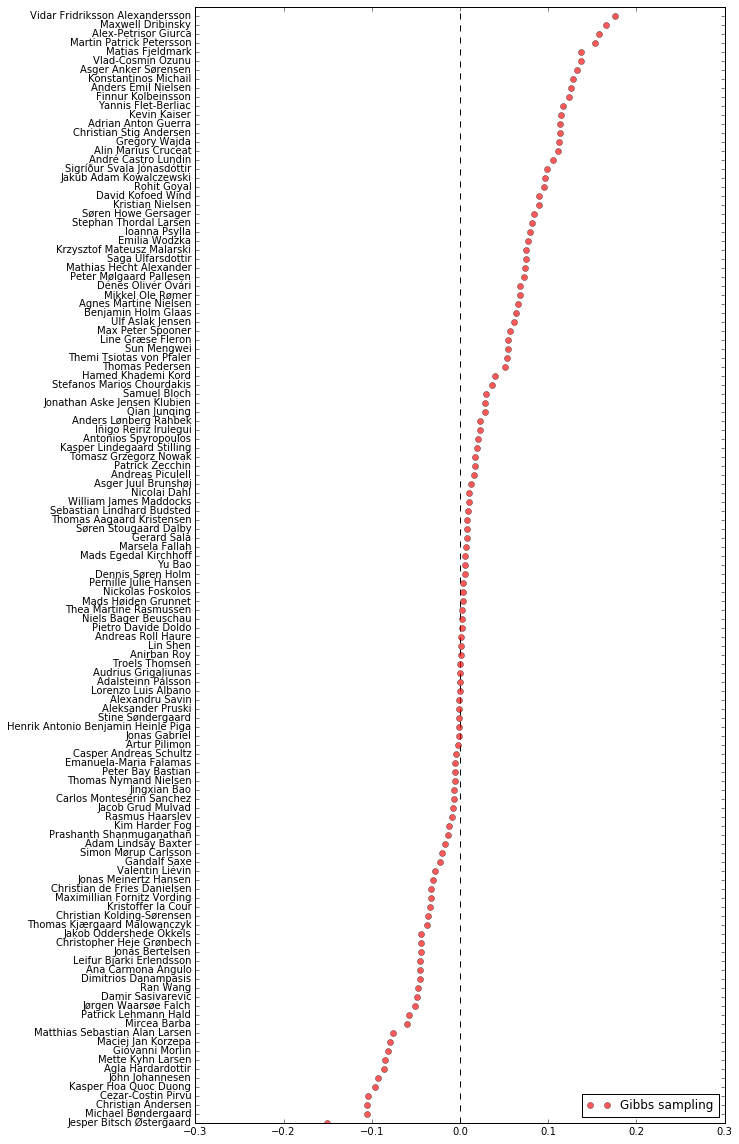

In [231]:
plot_bias(course_data,course_result)

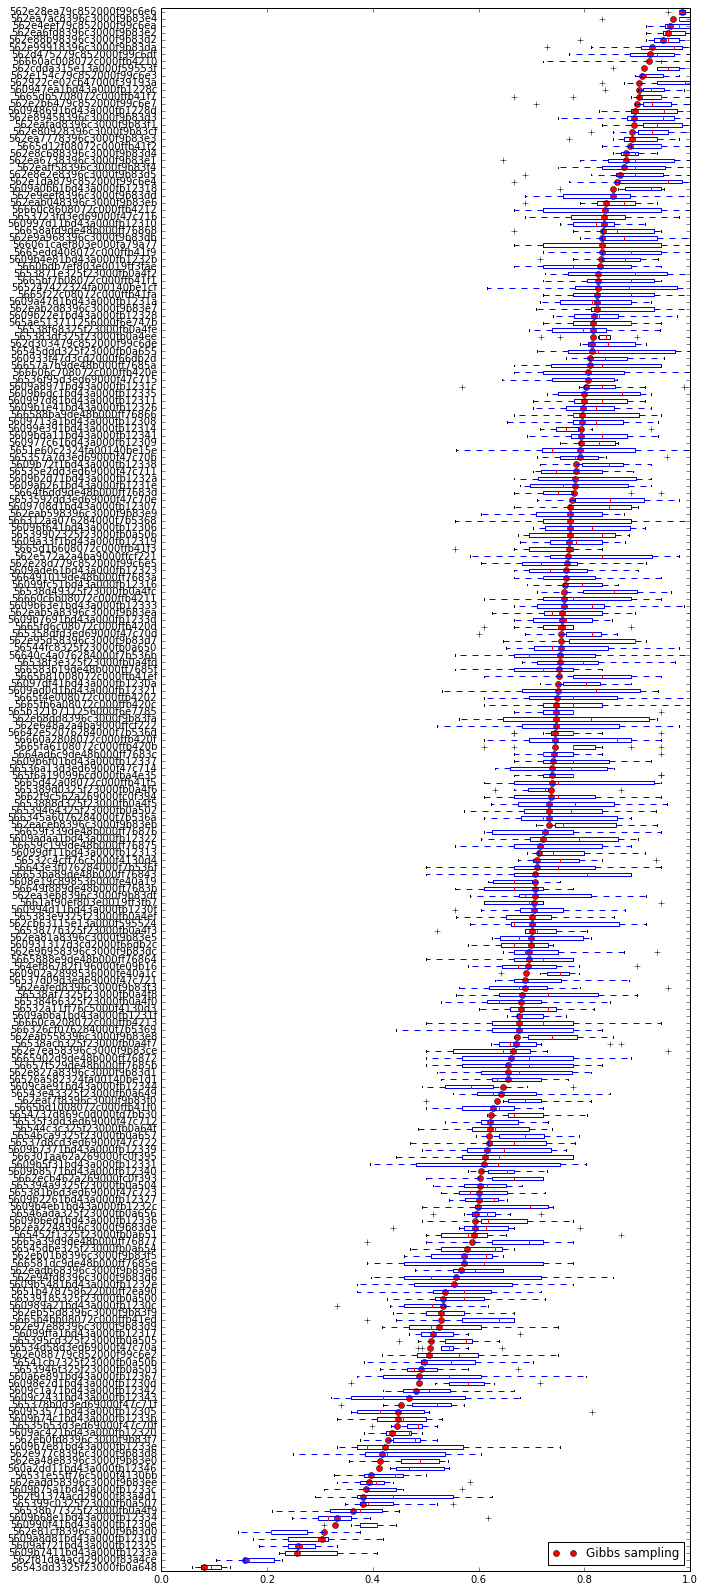

In [232]:
plot_handin_score(course_data,course_result)

## Assignment 1

In [277]:
a1 = data_model.Assignment.objects.get(title="UNIX, Python and Fast Data")

a1_data = fetch_data(a1)

a1_result = gibbs_model(a1_data)

6000 out of 6000


In [278]:
1.0 / a1_result['e']

0.009800642119339906

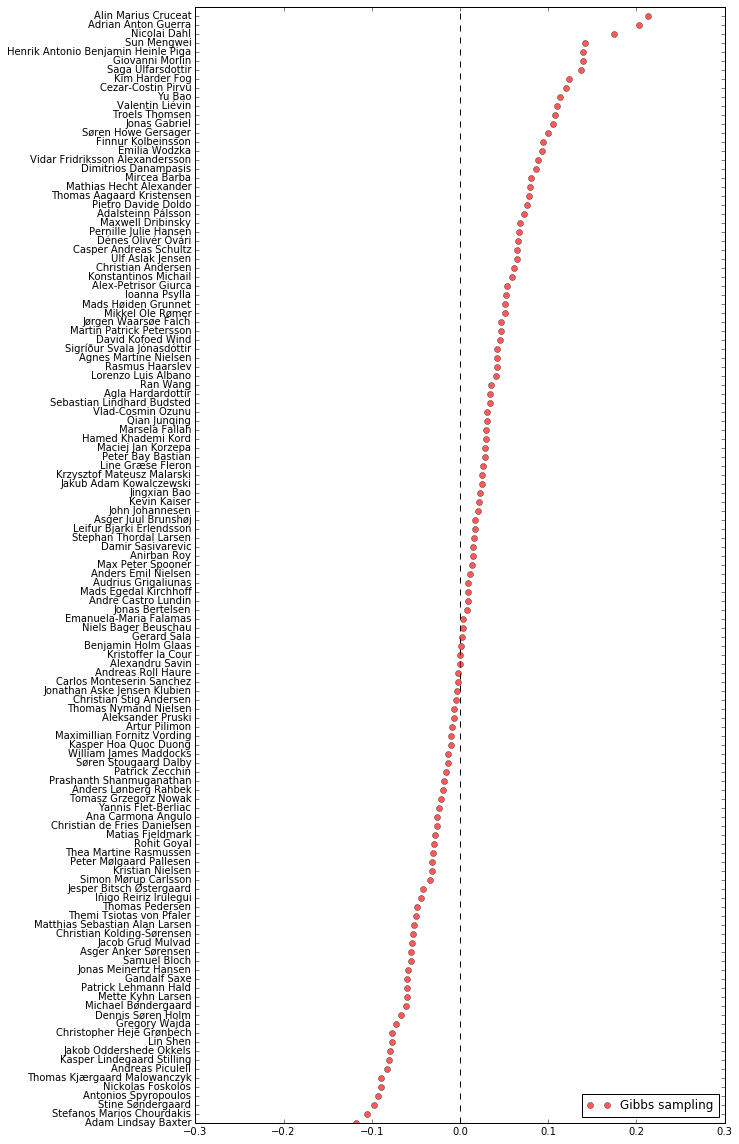

In [279]:
plot_bias(a1_data,a1_result)

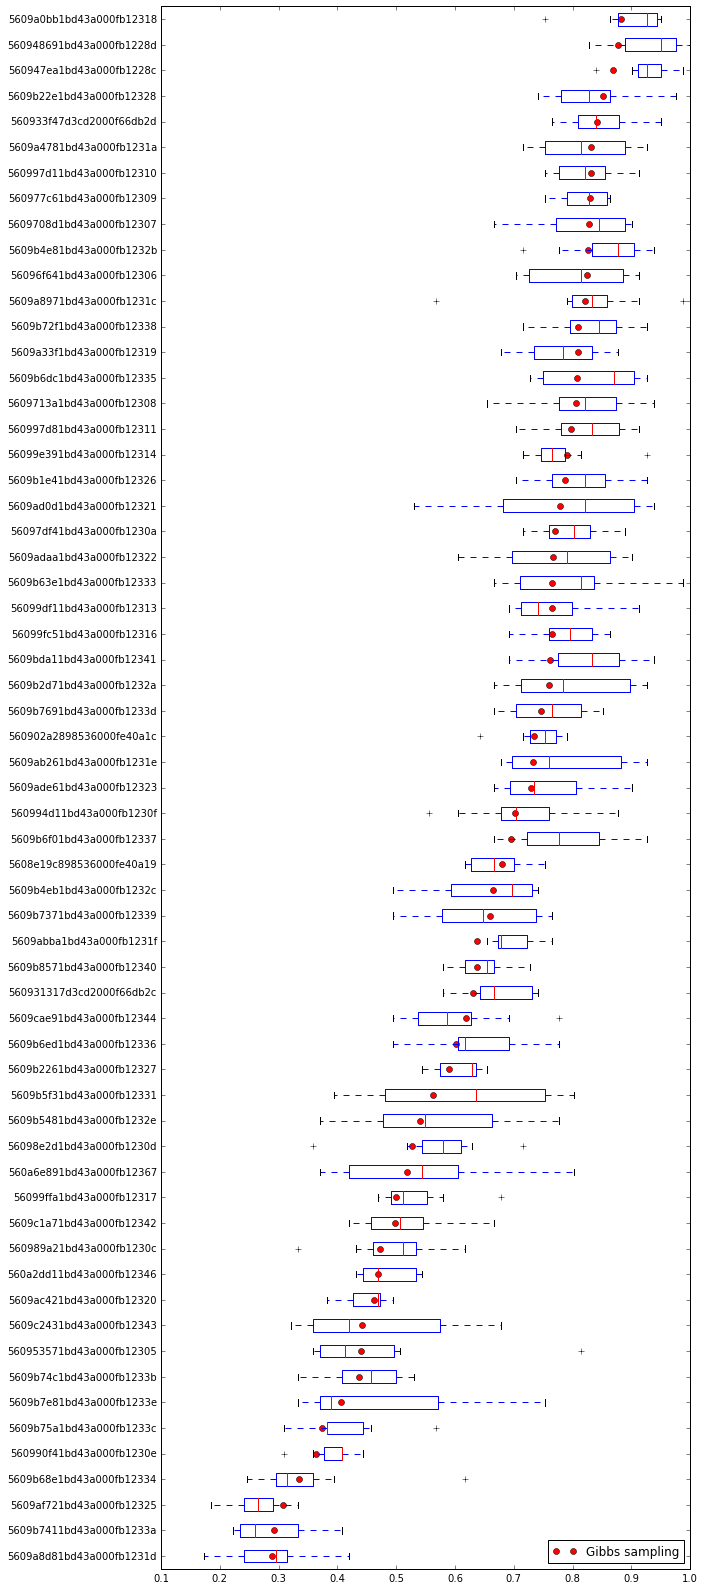

In [280]:
plot_handin_score(a1_data,a1_result)

## Assignment 2

In [214]:
a2 = data_model.Assignment.objects.get(title="Databases and Streaming")

a2_data = fetch_data(a2)

a2_result = gibbs_model(a2_data)

6000 out of 6000


In [215]:
1.0 / a2_result['e']

6.98624088992818e-05

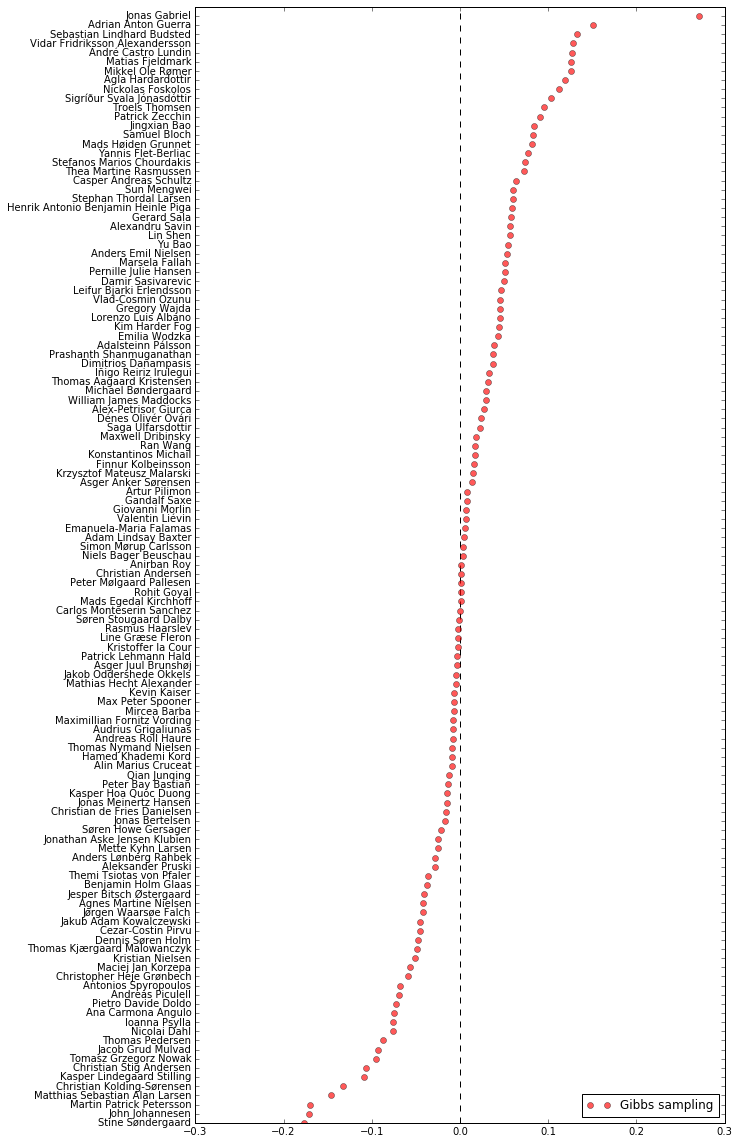

In [216]:
plot_bias(a2_data,a2_result)

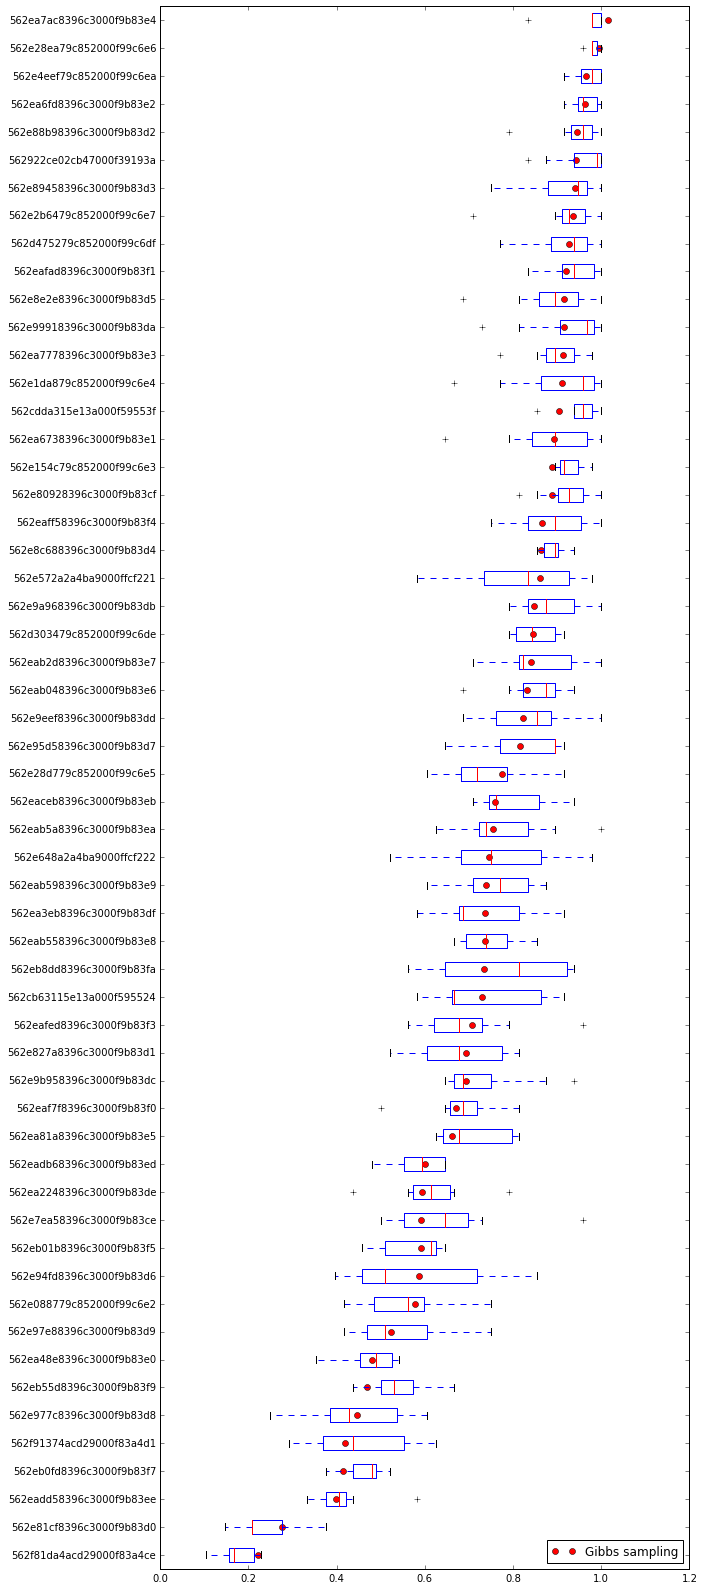

In [252]:
plot_handin_score(a2_data,a2_result)

## Assignment 3

In [218]:
a3 = data_model.Assignment.objects.get(title="Big Data and Deep Learning")

a3_data = fetch_data(a3)

a3_result = gibbs_model(a3_data)

6000 out of 6000


In [219]:
1.0 / a3_result['e']

5.7367466817918815e-05

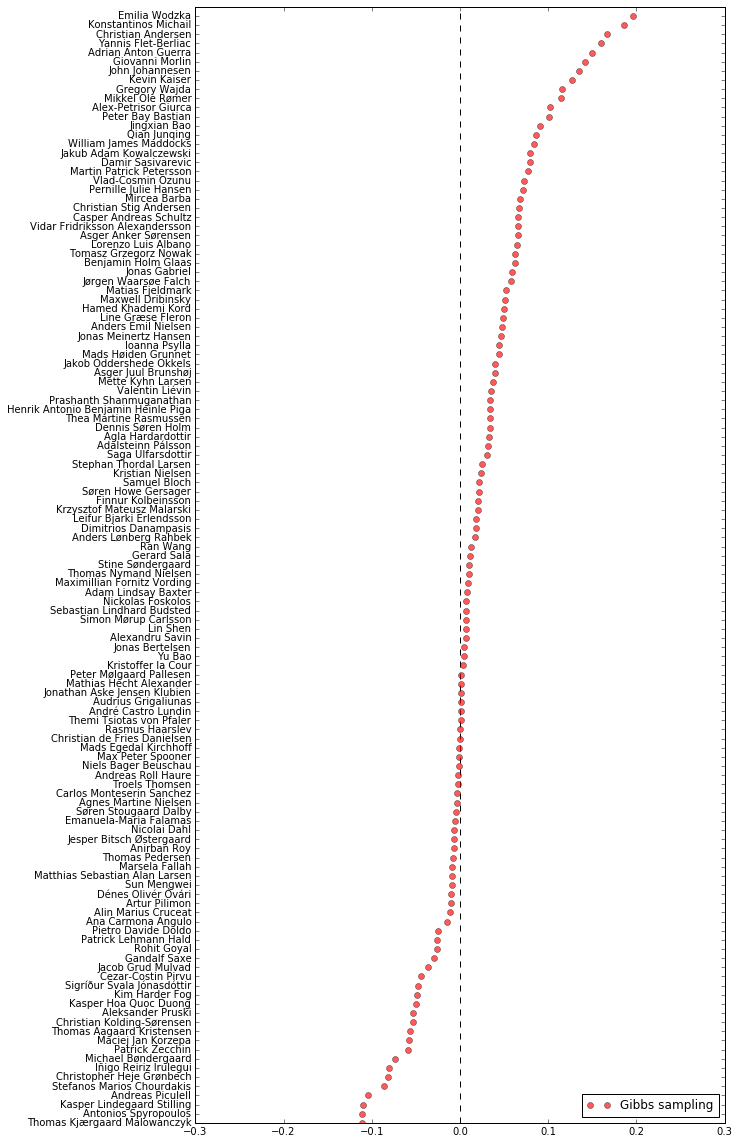

In [220]:
plot_bias(a3_data,a3_result)

In [221]:
sr = get_sorted_result(a3_data,a3_result)

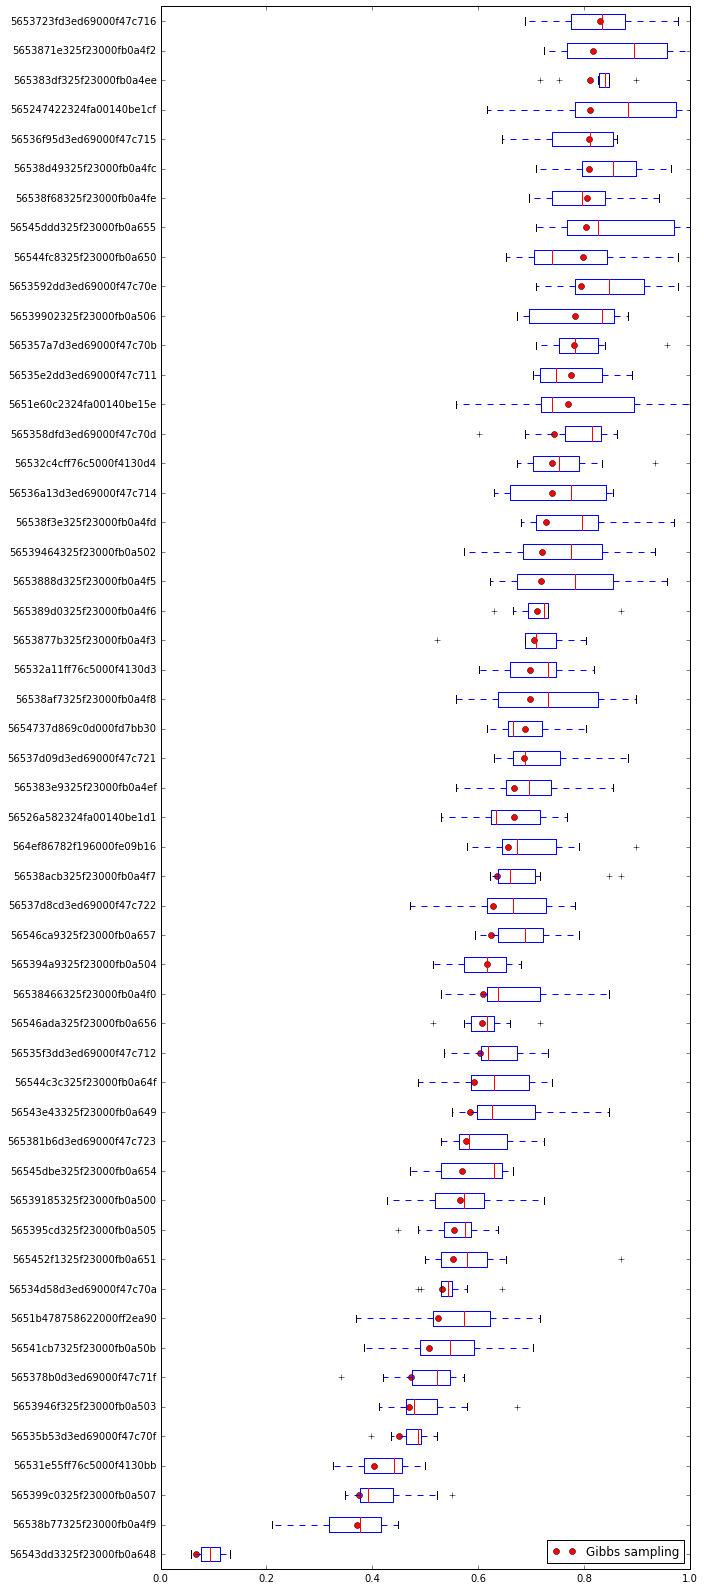

In [222]:
plot_handin_score(a3_data,a3_result)

## Assignment 4

In [223]:
a4 = data_model.Assignment.objects.get(title="Your Choice of Subject")

a4_data = fetch_data(a4)

a4_result = gibbs_model(a4_data)

6000 out of 6000


In [224]:
1.0 / a4_result['e']

8.463942284594051e-05

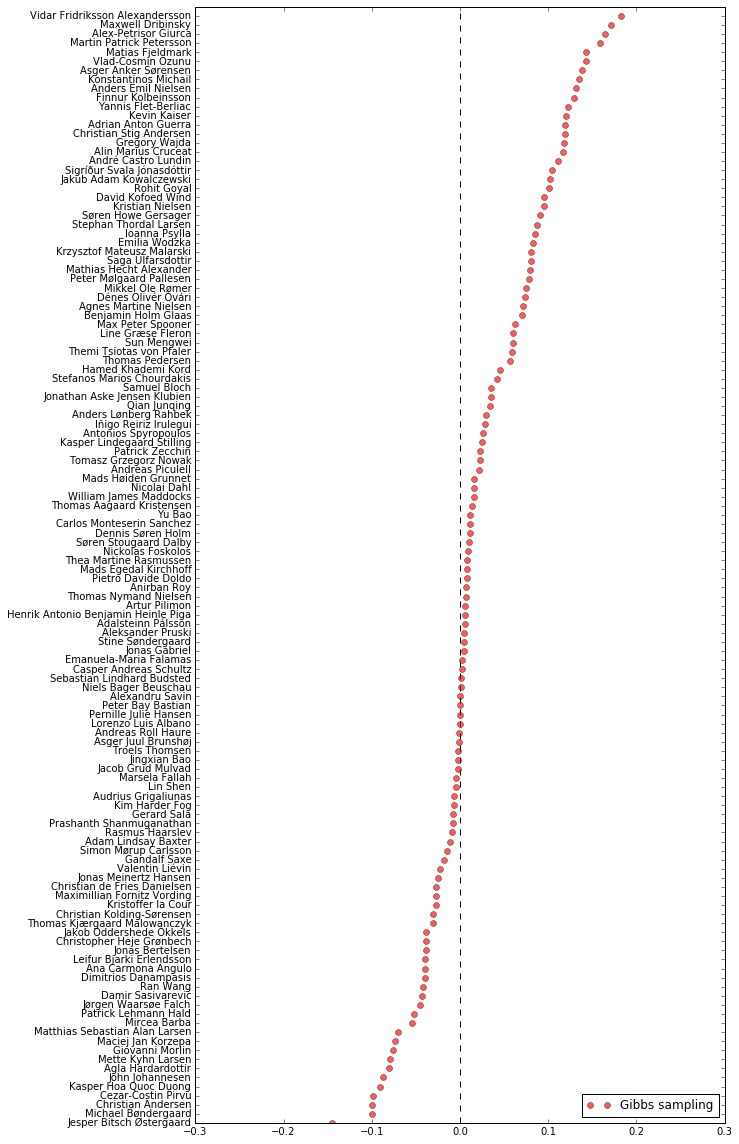

In [225]:
plot_bias(a4_data,a4_result)

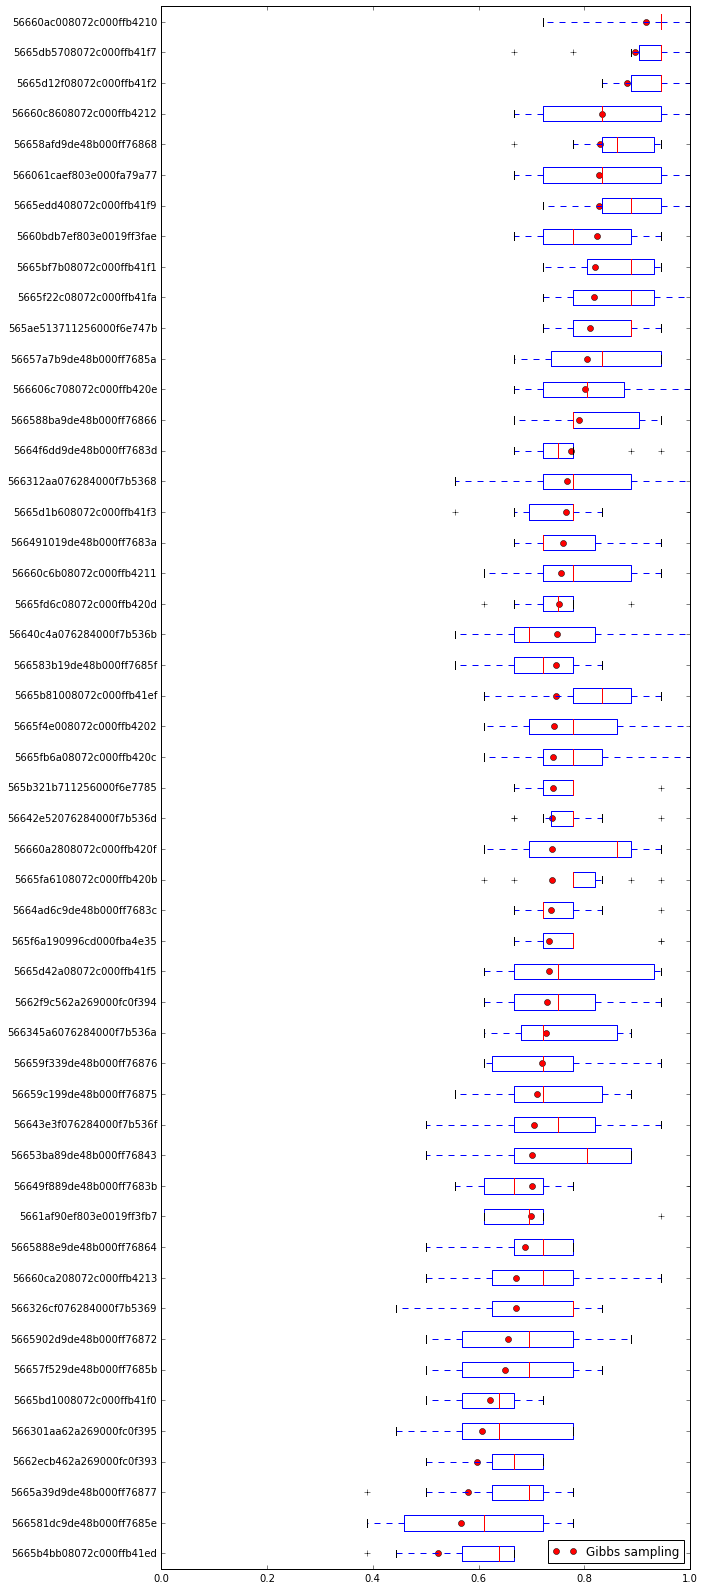

In [226]:
plot_handin_score(a4_data,a4_result)

In [1]:
def plot_all_grader_bias(data_result):
    
    grader_bias = defaultdict(list)
    
    for data,result in data_result:

        for name, g in t.graders.iteritems():
            grader_bias[name].append(result['B'][name])

    scores = list()
    
    for name, values in grader_bias.iteritems():
        scores.append((user_name(ObjectId(name)),values))
    
    ax = plt.subplot(111)

    scores.sort(key=lambda x:x[1])
    model_1 = map(lambda x : float(x[1]),scores)
    model_m = map(lambda x : np.mean(x[1]),scores)
    label = map(lambda x : x[0],scores)
    y = xrange(0,len(scores))
    plt.boxplot(model_1,positions=y, vert=False)
    plt.plot(model_m,y,'or',label="Gibbs sampling",alpha=0.65)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width+0.45, box.height*5])
    plt.yticks(xrange(0,len(scores)),label)
    plt.legend(loc=4)
    plt.title("Collected bias of the graders")
    plt.vlines(0, 0, len(scores), color="k", linestyles="--", lw=1)
    plt.ylabel("Grader")
    plt.xlabel("Bias")
    plt.show()

In [2]:
plot_all_grader_bias([(a1_data,a1_result),(a2_data,a2_result),(a3_data,a3_result),(a4_data,a4_result)])

NameError: name 'a1_data' is not defined

In [319]:
def print_bias(course_data,ass_data,name_in):

    print "Course:",
    sr = get_sorted_result(course_data[0],course_data[1])

    for name, value in sr:
        if name_in in name:
            print value

    sum_c = 0.0
    for i , (data,result) in enumerate(ass_data):
        print "Assignment %i:" % (i+1),
        sr = get_sorted_result(data,result)

        for name, value in sr:
            if name_in in name:
                print value
                sum_c = sum_c + value
    print "Mean: %f" % (sum_c / 4.0)

In [320]:
collected_ass_data = [(a1_data,a1_result),(a2_data,a2_result),(a3_data,a3_result),(a4_data,a4_result)]
collected_course_data = (course_data,course_result)

## closer look at  Jesper Bitcsh Østergaard

In [321]:
print_bias(collected_course_data,collected_ass_data,u'Jesper Bitsch Østergaard')

Course: -0.151254644612
Assignment 1: -0.0418719493713
Assignment 2: -0.0411227338533
Assignment 3: -0.00683644565457
Assignment 4: -0.145515832287
Mean: -0.058837


It seems that the bias in assignment 4 have a very heavy influence on the bias of the entire course which is not ideal

## Closer look at André Castro Lundin

In [322]:
print_bias(collected_course_data,collected_ass_data,u'Andr\xe9 Castro Lundin')

Course: 0.105845656625
Assignment 1: 0.00859951301103
Assignment 2: 0.127293313799
Assignment 3: 0.00107292322333
Assignment 4: 0.111747439796
Mean: 0.062178


The same as previously but this time it is in the positive direction

## Closer look at Jonas Gabriel

In [323]:
print_bias(collected_course_data,collected_ass_data,u'Jonas Gabriel')

Course: -0.001544046498
Assignment 1: 0.105043302249
Assignment 2: 0.270817184889
Assignment 3: 0.0591497037183
Assignment 4: 0.00422192345371
Mean: 0.109808


As we can see here the Grader is very much positive biased but if the model is used on the entire course the grader is presented as being netural even though that it is not the case.

## Closer look at Adrian Anton Guerra

In [324]:
print_bias(collected_course_data,collected_ass_data,u'Adrian Anton Guerra')

Course: 0.113549530343
Assignment 1: 0.203054360648
Assignment 2: 0.150933129194
Assignment 3: 0.150058610318
Assignment 4: 0.119413250691
Mean: 0.155865


Here we see a very positive biased person where the model is actually not giving the user grader as high a bias as he actully should have

## Closer look at myself, Thomas Kjærgaard Malowanczyk

In [325]:
print_bias(collected_course_data,collected_ass_data,u'Thomas Kjærgaard Malowanczyk')

Course: -0.0368624906522
Assignment 1: -0.0892354145469
Assignment 2: -0.0483535112276
Assignment 3: -0.111345425823
Assignment 4: -0.0310063683701
Mean: -0.069985


Here we see a more normal bias where I have received a negtive bias in most assignments. But the bias from the entore course is still lower than any of the bias in the assignments.

With this we can conclude that using MCMC on the entire course does not provide better result even though it provide more data.
The reson for the extreme result is hard to define as it is an unsubervised method so the underlying reasons in MCMC is not definable.
It can be assumed that taking MCMC over multiple assignments introduces more variables as each assignment can differe widely in both the subject, quality of the questions and the knowledge of the graders in both the subject and their abillity to grade.

The next question is if the same problem arrises as we look at handins as a question/task instead of a collection of questions.

In [326]:
print_bias(collected_course_data,collected_ass_data,u'Christopher Heje Grønbech')

Course: -0.0440840625957
Assignment 1: -0.0766746859288
Assignment 2: -0.0587217441611
Assignment 3: -0.0818907042282
Assignment 4: -0.0384273246846
Mean: -0.063929
